In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import scipy.io as sio
from datetime import datetime
from datetime import datetime, timedelta
from scipy.ndimage import binary_dilation

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules")
from utils import espra, smooth, robust_smooth


### IMOS Data

In [2]:
ssh_path = '/srv/scratch/z5297792/IN2023/2Drifter_Data/2Drifter_IMOS_Data.nc'
ssh_dataset = nc.Dataset(ssh_path, mode='r')

lon_ssh, lat_ssh = ssh_dataset['LONGITUDE'][:].data, ssh_dataset['LATITUDE'][:].data
lon_ssh, lat_ssh = np.meshgrid(lon_ssh, lat_ssh)
u_ssh, v_ssh = ssh_dataset['UCUR'][:].data, ssh_dataset['VCUR'][:].data # TIME, LATITUDE, LONGITUDE
u_ssh, v_ssh = np.transpose(u_ssh, axes=(2,1,0)), np.transpose(v_ssh, axes=(2,1,0)) # LON, LAT, TIME
tim_ssh = ssh_dataset['TIME'][:].data # days since 1985-01-01 00:00:00 UTC

ref_date = pd.Timestamp("1985-01-01 00:00:00")
tim_ssh = ref_date + pd.to_timedelta(tim_ssh, unit="D")

dic_ssh_data = {}
for t, time in enumerate(tim_ssh):
    ut, vt = u_ssh[:,:,t].T, v_ssh[:,:,t].T
    ut = np.where(np.abs(ut) < 4.9, ut, np.nan)
    vt = np.where(np.abs(vt) < 4.9, vt, np.nan)
    dic_ssh_data[time] = {'u': ut, 'v': vt}

theta_mean, phi_mean = np.float64(154.3), np.float64(-37.9)
x_ssh = (lon_ssh - theta_mean) * 111000 * np.cos(np.deg2rad(phi_mean))
y_ssh = (lat_ssh - phi_mean) * 111000


(np.float64(-503632.91714574234),
 np.float64(363491.5836790992),
 np.float64(-499500.0000000002),
 np.float64(477299.9999999998))

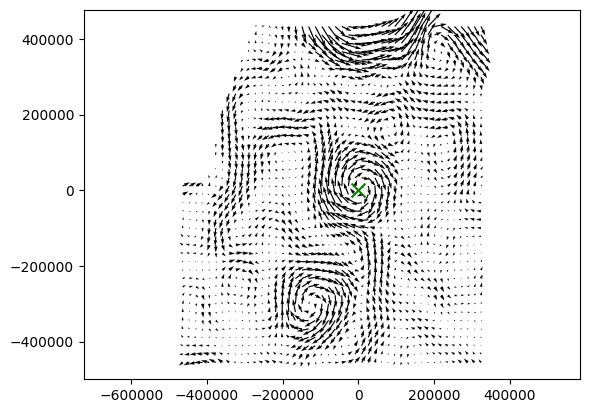

In [3]:
t_idx = 0
dic = dic_ssh_data[list(dic_ssh_data.keys())[t_idx]]
ut, vt = dic['u'], dic['v']
plt.quiver(x_ssh, y_ssh, ut, vt)
plt.scatter(0,0, marker='x', color='g', s=100)
plt.axis('equal')


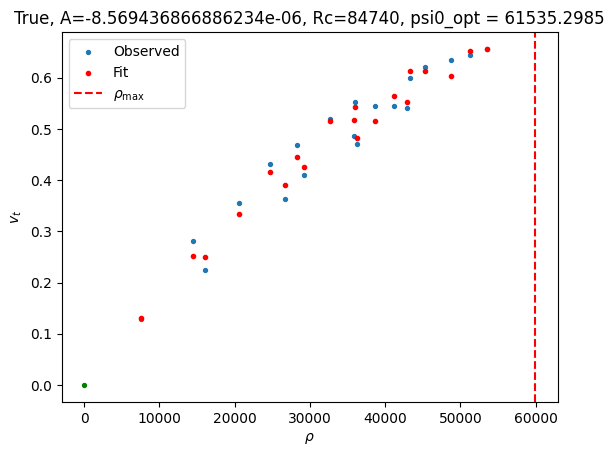

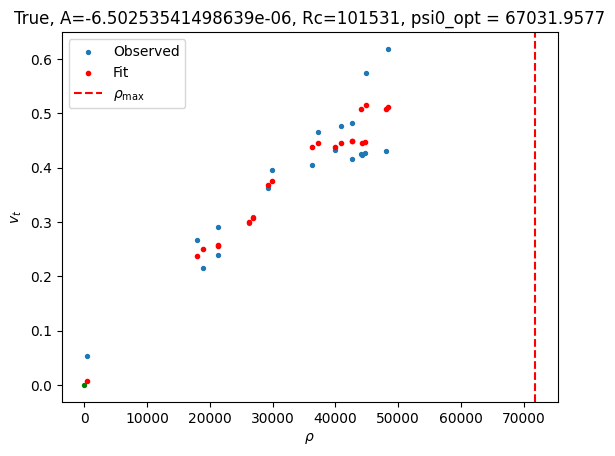

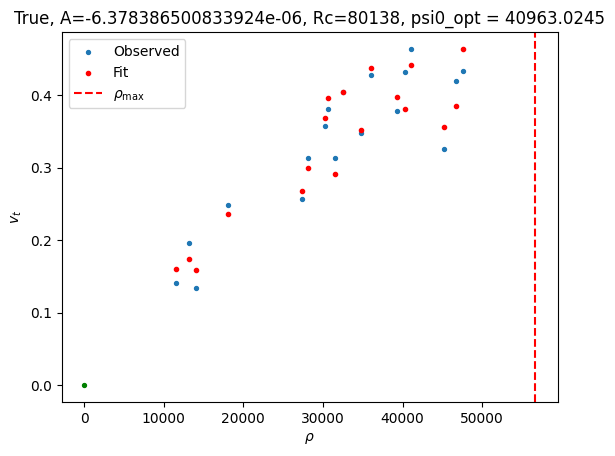

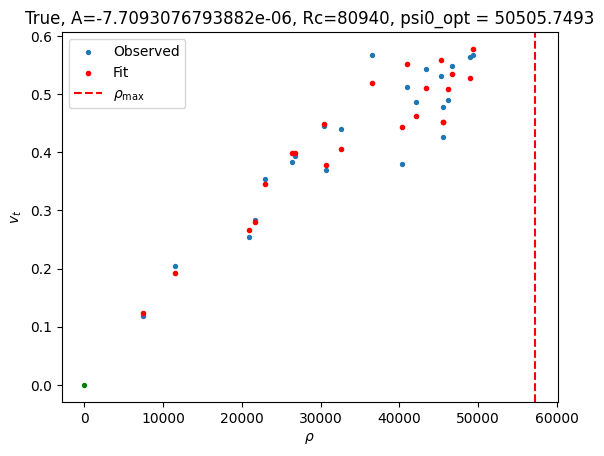

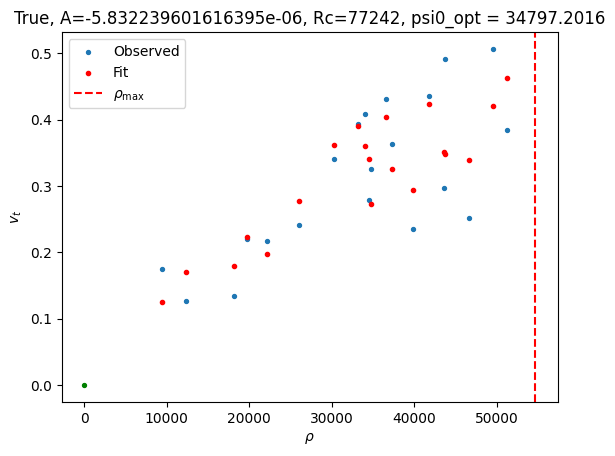

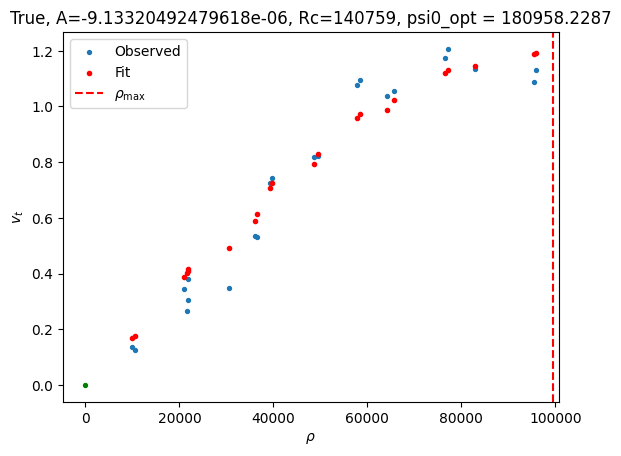

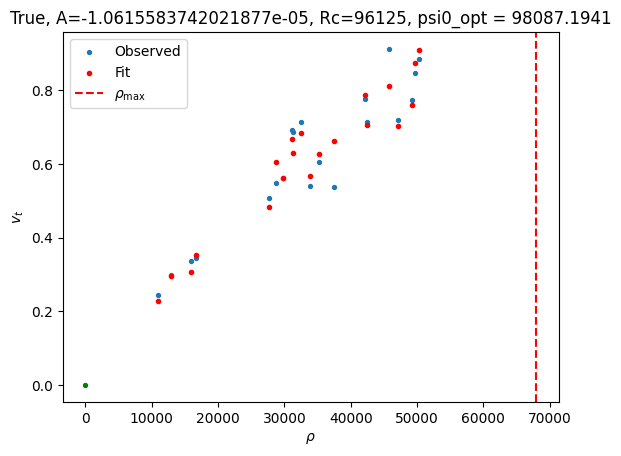

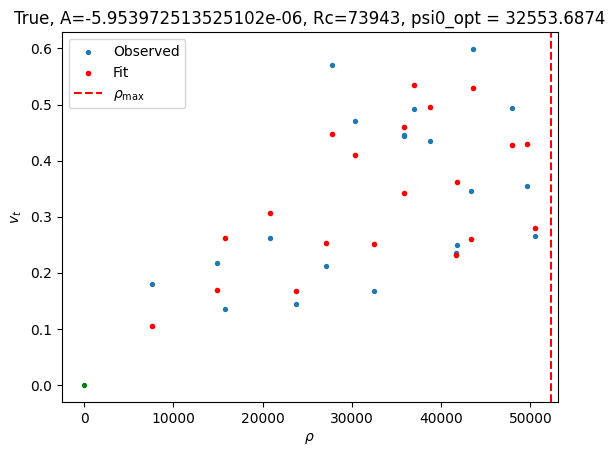

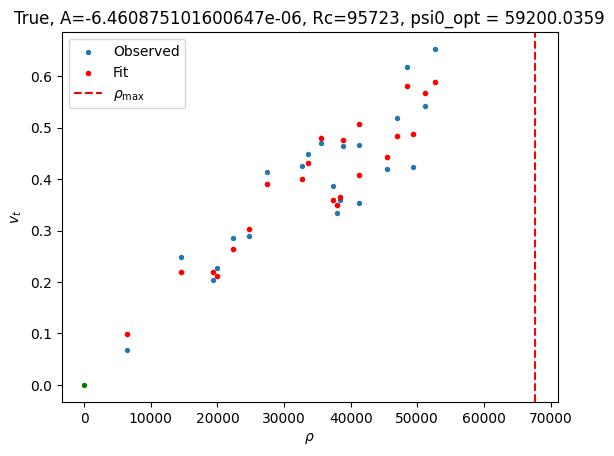

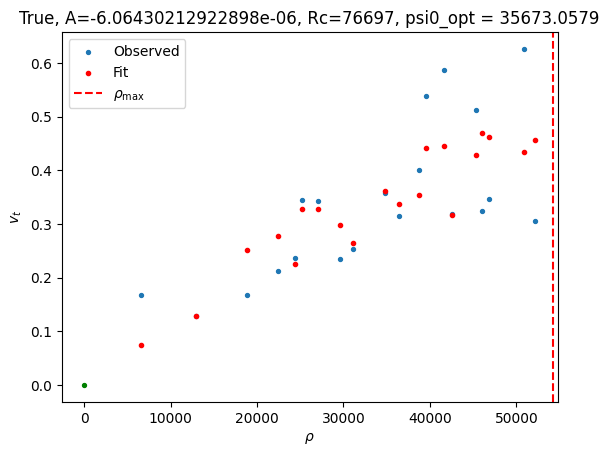

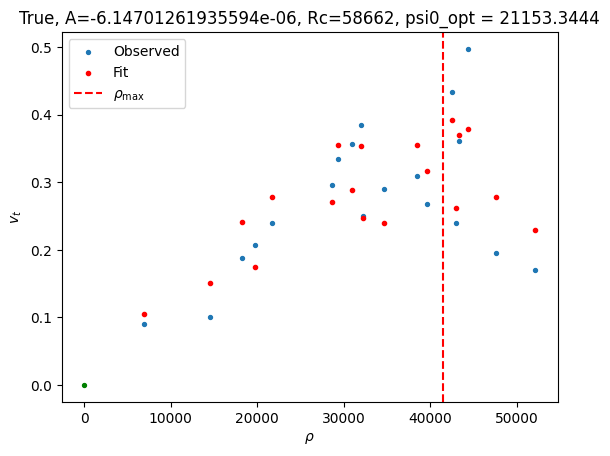

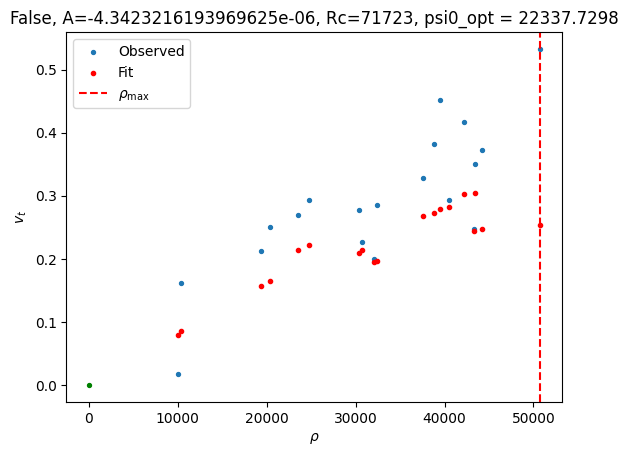

/home/z5297792/UNSW-MRes/MRes/modules/utils.py:406: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(vt_theo_func, rho2, vt, p0=[A_0, Rc_0], maxfev=10000)
/scratch/pbs.7070724.kman.restech.unsw.edu.au/ipykernel_354234/3790356614.py:10: RuntimeWarning: invalid value encountered in sqrt
  rho_search = np.sqrt(q11_pre*dx**2 + 2*q12_pre*dx*dy + q22_pre*dy**2)
/home/z5297792/UNSW-MRes/MRes/modules/utils.py:406: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(vt_theo_func, rho2, vt, p0=[A_0, Rc_0], maxfev=10000)


,xc,yc,w,Q,Rc,psi0,A,Time
0,3844.432520,5309.443027,-0.000027,"[[1.1501845463568723, 0.017300724757005077], [...",84739.522836,61535.298541,-0.000009,2023-10-18 18:00:00
1,4028.598606,6972.204595,-0.000027,"[[1.2378275192923252, 0.023327659822904585], [...",80246.164441,54339.958490,-0.000008,2023-10-19 18:00:00
2,4681.289277,6594.580785,-0.000029,"[[1.2612861582461656, 0.058724965753571515], [...",74088.602239,50772.808423,-0.000009,2023-10-20 18:00:00
3,2739.151927,8319.650798,-0.000028,"[[1.2387353809526243, 0.021655792499544215], [...",80390.711618,55790.858681,-0.000009,2023-10-21 18:00:00
4,1703.742792,8538.064814,-0.000026,"[[1.2294191619263521, 0.040962834132780054], [...",85209.522618,58234.907834,-0.000008,2023-10-22 18:00:00
...,...,...,...,...,...,...,...,...
113,-320982.739683,112616.982190,-0.000017,"[[1.86289582305675, -0.14197917492743228], [-0...",69398.066062,16776.801833,-0.000003,2024-02-04 06:00:00
114,-327113.425541,109345.437259,-0.000014,"[[2.035480441554206, -0.15444816339197331], [-...",72941.457765,14679.953566,-0.000003,2024-02-05 06:00:00
115,-329127.567714,100920.448426,-0.000008,"[[2.3533676994610513, -0.024034089676106093], ...",55165.148002,8434.934898,-0.000003,2024-02-06 06:00:00
116,-322125.926819,131527.067491,-0.000010,"[[1.9886299490910664, -0.3108610148420783], [-...",102070.135664,20213.313562,-0.000002,2024-02-07 06:00:00


In [4]:
xc_pre, yc_pre = 0, 0
q11_pre, q12_pre, q22_pre = 1, 0, 1
df_res = pd.DataFrame(columns=['xc', 'yc', 'w', 'Q', 'Rc', 'psi0', 'A', 'Time'])
rho_search_thresh = 50000
for k, t_idx in enumerate(range(len(dic_ssh_data))):
    dic = dic_ssh_data[list(dic_ssh_data.keys())[t_idx]]
    ut, vt = dic['u'], dic['v']

    dx, dy = x_ssh - xc_pre, y_ssh - yc_pre
    rho_search = np.sqrt(q11_pre*dx**2 + 2*q12_pre*dx*dy + q22_pre*dy**2)
    mask = rho_search < rho_search_thresh
    xi, yi, ui, vi = x_ssh[mask], y_ssh[mask], ut[mask], vt[mask]
    xc, yc, w, Q, Rc, psi0, A = espra(xi, yi, ui, vi, Rc_max=150000, plot_flag=True if k%10==0 else False)

    if (np.hypot(xc-xc_pre, yc-yc_pre)<100000) & (np.sign(w)<0):
        df_res.loc[len(df_res)] = {'xc': xc, 'yc': yc, 'w': w, 'Q': Q,
                                   'Rc': Rc, 'psi0': psi0, 'A': A, 'Time': list(dic_ssh_data.keys())[t_idx]}
        xc_pre, yc_pre = xc, yc
        q11_pre, q12_pre, q22_pre = Q[0,0], Q[1,0], Q[1,1]
    else:
        break
df_res


(np.float64(-345818.01056400995),
 np.float64(21371.732126693747),
 np.float64(-3818.7749864872903),
 np.float64(167943.0387510461))

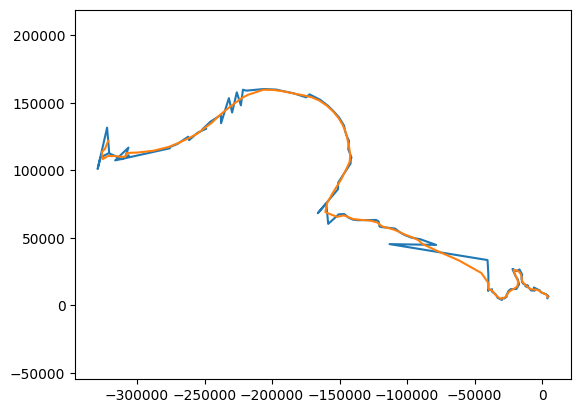

In [5]:
wdw = 3
df_res['sxc'] = smooth(df_res.xc, df_res.Time, window=wdw, num=len(df_res)) 
df_res['syc'] = smooth(df_res.yc, df_res.Time, window=wdw, num=len(df_res)) 

plt.plot(df_res.xc, df_res.yc)
plt.plot(df_res.sxc, df_res.syc)
plt.axis('equal')


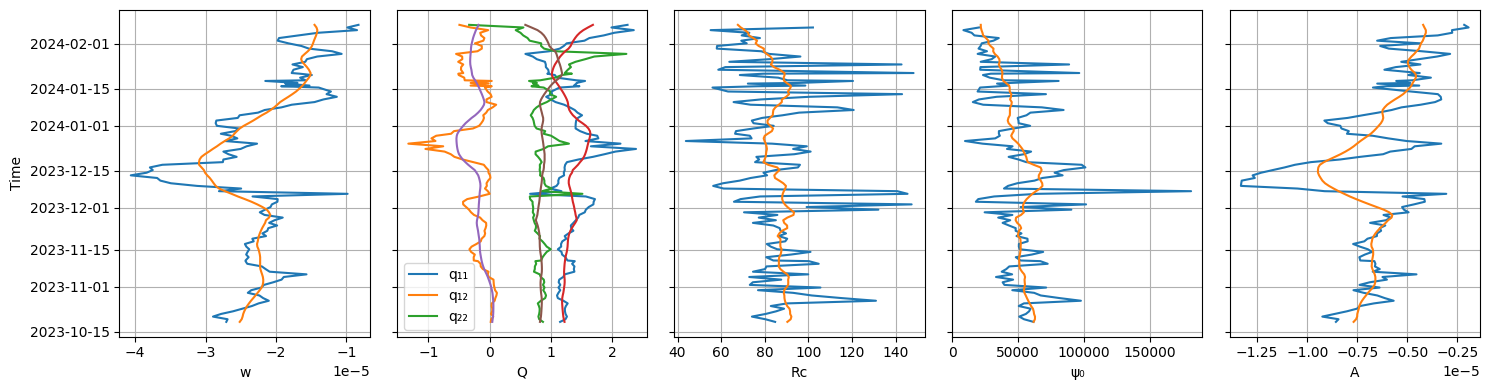

In [6]:
wdw = 20
df_res['sw'] = smooth(df_res.w, df_res.Time, window=wdw, num=len(df_res)) 
df_res['sq11'] = smooth(df_res.Q.apply(lambda Q: Q[0,0]), df_res.Time, window=wdw, num=len(df_res)) 
df_res['sq12'] = smooth(df_res.Q.apply(lambda Q: Q[0,1]), df_res.Time, window=wdw, num=len(df_res)) 
df_res['sq22'] = smooth(df_res.Q.apply(lambda Q: Q[1,1]), df_res.Time, window=wdw, num=len(df_res)) 
df_res['sRc'] = smooth(df_res.Rc, df_res.Time, window=wdw, num=len(df_res)) 
df_res['spsi0'] = smooth(df_res.psi0, df_res.Time, window=wdw, num=len(df_res)) 
df_res['sA'] = smooth(df_res.A, df_res.Time, window=wdw, num=len(df_res)) 

fig, axs = plt.subplots(1, 5, figsize=(15,4), sharey=True)

axs[0].plot(df_res.w, df_res.Time)
axs[0].plot(df_res.sw, df_res.Time)
axs[0].set_xlabel('w')

axs[1].plot(df_res.Q.apply(lambda Q: Q[0,0]), df_res.Time, label='q₁₁')
axs[1].plot(df_res.Q.apply(lambda Q: Q[0,1]), df_res.Time, label='q₁₂')
axs[1].plot(df_res.Q.apply(lambda Q: Q[1,1]), df_res.Time, label='q₂₂')
axs[1].plot(df_res.sq11, df_res.Time)
axs[1].plot(df_res.sq12, df_res.Time)
axs[1].plot(df_res.sq22, df_res.Time)
axs[1].set_xlabel('Q')
axs[1].legend()

axs[2].plot(df_res.Rc/1000, df_res.Time)
axs[2].plot(df_res.sRc/1000, df_res.Time)
axs[2].set_xlabel('Rc')

axs[3].plot(df_res.psi0, df_res.Time)
axs[3].plot(df_res.spsi0, df_res.Time)
axs[3].set_xlabel('ψ₀')

axs[4].plot(df_res.A, df_res.Time)
axs[4].plot(df_res.sA, df_res.Time)
axs[4].set_xlabel('A')

for ax in axs:
    ax.grid(True)
axs[0].set_ylabel('Time')

plt.tight_layout()


Text(0.5, 1.0, '2023-11-07 18:00:00')

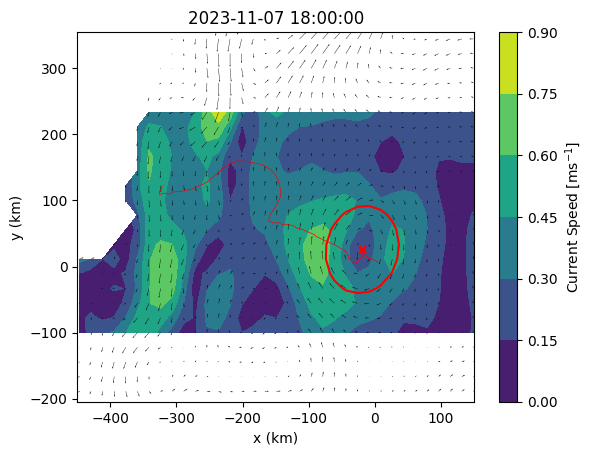

In [7]:
t_idx = 20
data = df_res.iloc[t_idx]

closest = min(tim_ssh, key=lambda tt: abs(tt - data.Time))
ut, vt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']
mask = (x_ssh/1e3>=-450)&(x_ssh/1e3<=150)&(y_ssh/1e3>=-100)&(y_ssh/1e3<=250)
ut_mask, vt_mask = np.where(mask, ut, np.nan), np.where(mask, vt, np.nan)
plt.contourf(x_ssh/1e3, y_ssh/1e3, np.hypot(ut_mask, vt_mask))
plt.colorbar(label=r'Current Speed [ms$^{-1}$]')
plt.quiver(x_ssh/1e3, y_ssh/1e3, ut, vt, width=.001, scale=30)
plt.plot(df_res.sxc/1e3, df_res.syc/1e3, lw=.5, color='r')

plt.scatter(data.sxc/1e3, data.syc/1e3, marker='x', color='r', s=25, zorder=3)

dx_ell, dy_ell = x_ssh/1e3 - data.sxc/1e3, y_ssh/1e3 - data.syc/1e3
rho2_ell = data.sq11*dx_ell**2 + 2*data.sq12*dx_ell*dy_ell + data.sq22*dy_ell**2
plt.contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2],
            colors='r', zorder=3)

plt.xlabel('x (km)'); plt.ylabel('y (km)')
plt.axis('equal')
plt.xlim(-450, 150); plt.ylim(-100, 250)
plt.title(f'{list(dic_ssh_data.keys())[t_idx]}')



In [8]:
X, Y = x_ssh, y_ssh

U = np.zeros((X.shape[0], X.shape[1], len(df_res)))
V = np.zeros((X.shape[0], X.shape[1], len(df_res)))

for k in range(len(df_res)):
    data = df_res.iloc[k]
    dx, dy = X - data.sxc, Y - data.syc
    rho2 = data.sq11*dx**2 + 2*data.sq12*dx*dy + data.sq22*dy**2

    U[:,:,k] = - data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.sq12*dx + 2*data.sq22*dy )
    V[:,:,k] =   data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.sq11*dx + 2*data.sq12*dy ) 


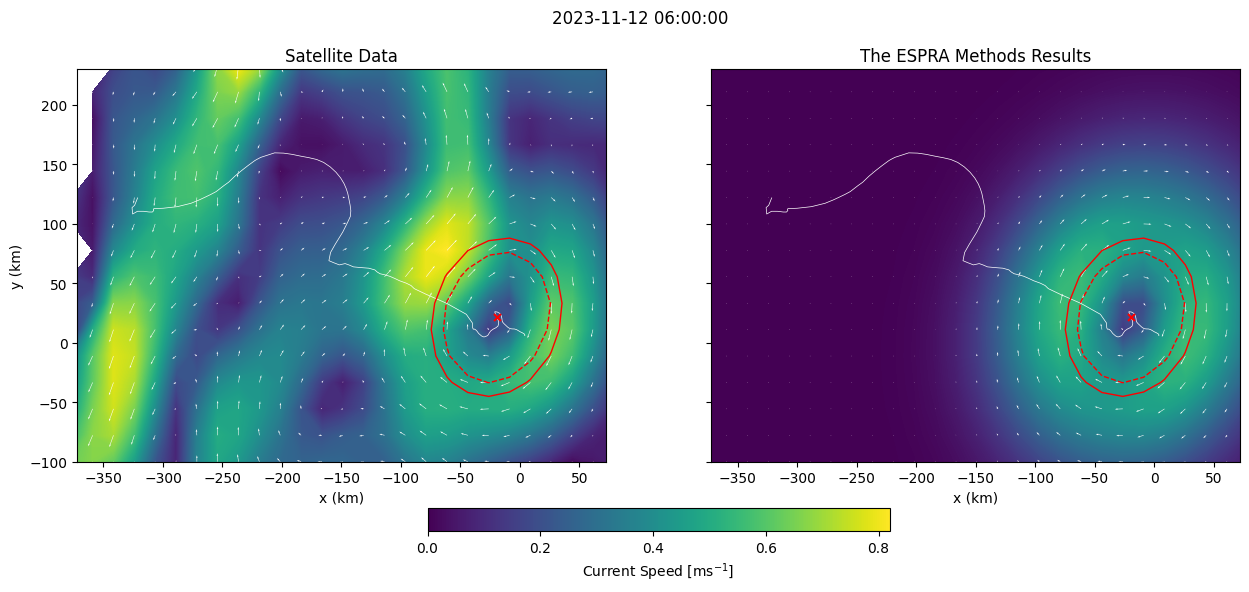

In [27]:
t_idx = 25
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

data = df_res.iloc[t_idx]

# data & masks
closest = min(tim_ssh, key=lambda tt: abs(tt - data.Time))
ut, vt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']
mask = (x_ssh/1e3>=-450)&(x_ssh/1e3<=150)&(y_ssh/1e3>=-100)&(y_ssh/1e3<=250)
ut_mask, vt_mask = np.where(mask, ut, np.nan), np.where(mask, vt, np.nan)
spd1 = np.hypot(ut_mask, vt_mask)

u, v = U[:,:,t_idx], V[:,:,t_idx]
spd2 = np.hypot(u, v)

# shared colour scale: force 0 baseline, use combined max, and FIX levels
vmin = 0.0
vmax = np.nanmax(np.concatenate([spd1.ravel(), spd2.ravel()]))
cmap = 'viridis'
levels = np.linspace(vmin, vmax, 256)  # identical bins for both
norm = plt.Normalize(vmin, vmax)

# --- plot 1 ---
cf1 = axs[0].contourf(x_ssh/1e3, y_ssh/1e3, spd1, levels=levels, cmap=cmap, norm=norm, extend='neither')
axs[0].quiver(x_ssh/1e3, y_ssh/1e3, ut_mask, vt_mask, width=.001, scale=30, color='w')
axs[0].plot(df_res.sxc/1e3, df_res.syc/1e3, lw=.5, color='w')
dx_ell, dy_ell = x_ssh/1e3 - data.sxc/1e3, y_ssh/1e3 - data.syc/1e3
rho2_ell = data.sq11*dx_ell**2 + 2*data.sq12*dx_ell*dy_ell + data.sq22*dy_ell**2
axs[0].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2], colors='r', zorder=3, linewidths=1)
axs[0].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(rho_search_thresh/1e3)**2],
               colors='r', zorder=3, linewidths=1, linestyles='--')
axs[0].scatter(data.sxc/1e3, data.syc/1e3, marker='x', color='r', s=25, zorder=3)
axs[0].axis('equal'); axs[0].set_xlabel('x (km)'); axs[0].set_ylabel('y (km)')
axs[0].set_xlim(-450, 150); axs[0].set_ylim(-100, 230); axs[0].set_title('Satellite Data')

# --- plot 2 ---
cf2 = axs[1].contourf(X/1e3, Y/1e3, spd2, levels=levels, cmap=cmap, norm=norm, extend='neither')
spac = 1
axs[1].quiver(X[::spac,::spac]/1e3, Y[::spac,::spac]/1e3,
              u[::spac,::spac], v[::spac,::spac], width=.001, scale=30, color='w')
axs[1].plot(df_res.sxc/1e3, df_res.syc/1e3, lw=.5, color='w')
axs[1].scatter(data.sxc/1e3, data.syc/1e3, marker='x', color='r', s=25, zorder=3)
axs[1].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2], colors='r', zorder=3, linewidths=1)
axs[1].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(rho_search_thresh/1e3)**2],
               colors='r', zorder=3, linewidths=1, linestyles='--')
axs[1].axis('equal'); axs[1].set_xlabel('x (km)'); axs[1].set_title('The ESPRA Methods Results')
axs[1].set_xlim(-450, 150); axs[1].set_ylim(-100, 230)

# shared colourbar reflects exactly those shared levels
cbar = fig.colorbar(cf2, ax=axs, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label(r'Current Speed [ms$^{-1}$]')
cbar.set_ticks(np.linspace(vmin, round(vmax, 1), 5))
# plt.tight_layout()
fig.suptitle(f'{list(dic_ssh_data.keys())[t_idx]}')
plt.show()


In [24]:
# # MOVIE
# for t_idx in range(len(df_res)):
#     fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
    
#     data = df_res.iloc[t_idx]
    
#     # data & masks
#     closest = min(tim_ssh, key=lambda tt: abs(tt - data.Time))
#     ut, vt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']
#     mask = (x_ssh/1e3>=-450)&(x_ssh/1e3<=150)&(y_ssh/1e3>=-100)&(y_ssh/1e3<=250)
#     ut_mask, vt_mask = np.where(mask, ut, np.nan), np.where(mask, vt, np.nan)
#     spd1 = np.hypot(ut_mask, vt_mask)
    
#     u, v = U[:,:,t_idx], V[:,:,t_idx]
#     spd2 = np.hypot(u, v)
    
#     # shared colour scale: force 0 baseline, use combined max, and FIX levels
#     vmin = 0.0
#     # vmax = np.nanmax(np.concatenate([spd1.ravel(), spd2.ravel()]))
#     vmax = 1.0
#     cmap = 'viridis'
#     levels = np.linspace(vmin, vmax, 256)  # identical bins for both
#     norm = plt.Normalize(vmin, vmax)
    
#     # --- plot 1 ---
#     cf1 = axs[0].contourf(x_ssh/1e3, y_ssh/1e3, spd1, levels=levels, cmap=cmap, norm=norm, extend='neither')
#     axs[0].quiver(x_ssh/1e3, y_ssh/1e3, ut_mask, vt_mask, width=.001, scale=30, color='w')
#     axs[0].plot(df_res.sxc/1e3, df_res.syc/1e3, lw=.5, color='w')
#     dx_ell, dy_ell = x_ssh/1e3 - data.sxc/1e3, y_ssh/1e3 - data.syc/1e3
#     rho2_ell = data.sq11*dx_ell**2 + 2*data.sq12*dx_ell*dy_ell + data.sq22*dy_ell**2
#     axs[0].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2], colors='r', zorder=3, linewidths=1)
#     axs[0].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(rho_search_thresh/1e3)**2],
#                colors='r', zorder=3, linewidths=1, linestyles='--')
#     axs[0].scatter(data.sxc/1e3, data.syc/1e3, marker='x', color='r', s=25, zorder=3)
#     axs[0].axis('equal'); axs[0].set_xlabel('x (km)'); axs[0].set_ylabel('y (km)')
#     axs[0].set_xlim(-450, 150); axs[0].set_ylim(-100, 230); axs[0].set_title('Satellite Data')
    
#     # --- plot 2 ---
#     cf2 = axs[1].contourf(X/1e3, Y/1e3, spd2, levels=levels, cmap=cmap, norm=norm, extend='neither')
#     spac = 1
#     axs[1].quiver(X[::spac,::spac]/1e3, Y[::spac,::spac]/1e3,
#                   u[::spac,::spac], v[::spac,::spac], width=.001, scale=30, color='w')
#     axs[1].plot(df_res.sxc/1e3, df_res.syc/1e3, lw=.5, color='w')
#     axs[1].scatter(data.sxc/1e3, data.syc/1e3, marker='x', color='r', s=25, zorder=3)
#     axs[1].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2], colors='r', zorder=3, linewidths=1)
#     axs[1].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(rho_search_thresh/1e3)**2],
#                colors='r', zorder=3, linewidths=1, linestyles='--')
#     axs[1].axis('equal'); axs[1].set_xlabel('x (km)'); axs[1].set_title('The DOPIOE Methods Results')
#     axs[1].set_xlim(-450, 150); axs[1].set_ylim(-100, 230)
    
#     # shared colourbar reflects exactly those shared levels
#     cbar = fig.colorbar(cf2, ax=axs, orientation='horizontal', fraction=0.05, pad=0.1)
#     cbar.set_label(r'Current Speed [ms$^{-1}$]')
#     cbar.set_ticks(np.linspace(vmin, round(vmax, 1), 5))

#     fig.suptitle(f'{list(dic_ssh_data.keys())[t_idx]}')
#     plt.savefig(f'/srv/scratch/z5297792/ESP_Paper_Data/ESPRA_IMOS_Data/tracking_images/frame_{t_idx:03d}.png', dpi=300, bbox_inches='tight')
#     plt.close()



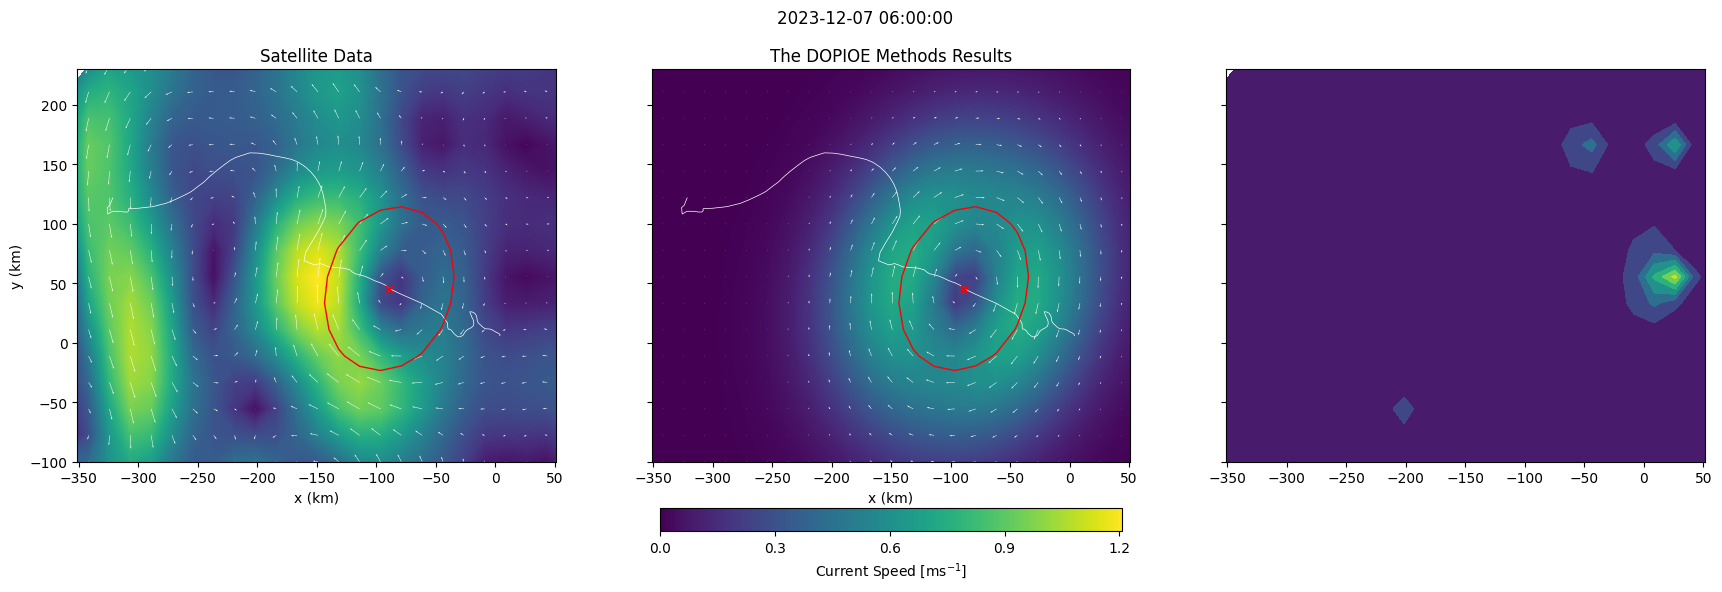

In [28]:
t_idx = 50
fig, axs = plt.subplots(1, 3, figsize=(21, 6), sharey=True)

data = df_res.iloc[t_idx]

# data & masks
closest = min(tim_ssh, key=lambda tt: abs(tt - data.Time))
ut, vt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']
mask = (x_ssh/1e3>=-450)&(x_ssh/1e3<=150)&(y_ssh/1e3>=-100)&(y_ssh/1e3<=250)
ut_mask, vt_mask = np.where(mask, ut, np.nan), np.where(mask, vt, np.nan)
spd1 = np.hypot(ut_mask, vt_mask)

u, v = U[:,:,t_idx], V[:,:,t_idx]
spd2 = np.hypot(u, v)

rel_err = np.abs(spd2 - spd1) / np.abs(spd1) * 100

# shared colour scale: force 0 baseline, use combined max, and FIX levels
vmin = 0.0
vmax = np.nanmax(np.concatenate([spd1.ravel(), spd2.ravel()]))
cmap = 'viridis'
levels = np.linspace(vmin, vmax, 256)  # identical bins for both
norm = plt.Normalize(vmin, vmax)

# --- plot 1 ---
cf1 = axs[0].contourf(x_ssh/1e3, y_ssh/1e3, spd1, levels=levels, cmap=cmap, norm=norm, extend='neither')
axs[0].quiver(x_ssh/1e3, y_ssh/1e3, ut_mask, vt_mask, width=.001, scale=30, color='w')
axs[0].plot(df_res.sxc/1e3, df_res.syc/1e3, lw=.5, color='w')
dx_ell, dy_ell = x_ssh/1e3 - data.sxc/1e3, y_ssh/1e3 - data.syc/1e3
rho2_ell = data.sq11*dx_ell**2 + 2*data.sq12*dx_ell*dy_ell + data.sq22*dy_ell**2
axs[0].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2], colors='r', zorder=3, linewidths=1)
axs[0].scatter(data.sxc/1e3, data.syc/1e3, marker='x', color='r', s=25, zorder=3)
axs[0].axis('equal'); axs[0].set_xlabel('x (km)'); axs[0].set_ylabel('y (km)')
axs[0].set_xlim(-450, 150); axs[0].set_ylim(-100, 230); axs[0].set_title('Satellite Data')

# --- plot 2 ---
cf2 = axs[1].contourf(X/1e3, Y/1e3, spd2, levels=levels, cmap=cmap, norm=norm, extend='neither')
spac = 1
axs[1].quiver(X[::spac,::spac]/1e3, Y[::spac,::spac]/1e3,
              u[::spac,::spac], v[::spac,::spac], width=.001, scale=30, color='w')
axs[1].plot(df_res.sxc/1e3, df_res.syc/1e3, lw=.5, color='w')
axs[1].scatter(data.sxc/1e3, data.syc/1e3, marker='x', color='r', s=25, zorder=3)
axs[1].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2], colors='r', zorder=3, linewidths=1)
axs[1].axis('equal'); axs[1].set_xlabel('x (km)'); axs[1].set_title('The DOPIOE Methods Results')
axs[1].set_xlim(-450, 150); axs[1].set_ylim(-100, 230)

# --- plot 3 ---
axs[2].contourf(X/1e3, Y/1e3, rel_err)
axs[2].axis('equal'); axs[2].set_xlim(-450, 150); axs[2].set_ylim(-100, 230)

# shared colourbar reflects exactly those shared levels
cbar = fig.colorbar(cf2, ax=axs, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label(r'Current Speed [ms$^{-1}$]')
cbar.set_ticks(np.linspace(vmin, round(vmax, 1), 5))
# plt.tight_layout()
fig.suptitle(f'{list(dic_ssh_data.keys())[t_idx]}')
plt.show()
